# Model 1: Low resolution Detection of flooded tiles

The output of this model is used to train model 2

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import src.baseline_model01 as bm
import os
from xrspatial.focal import apply
from xrspatial.convolution import circle_kernel
from explainerdashboard import ClassifierExplainer, ExplainerDashboard


/home/michael/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Pre processing

The constructor handle a small amount of data processing :

* Pre-processing of the static data 
* Construction of the labels from raw data
* Loading of the dynamic data

And the splitting of the dataset into test / train / validation set follonwing defined start date and end date. The validation set could be useful as an alternative for Cross Validation to find optimal hyper-parameters.

In [2]:
baseline_model_generator = bm.BaseLineModel(
    "localdata/final_label_Full_ERA5.nc",
    dynamic_features_path = "localdata/raw/ERA5_train.nc",
    static_features_path = "localdata/static_ERA5.nc",
    train_start = "2002-08-03", # date where to split train test
    train_end = "2003-01-01", # date where to split train test
    test_start = "2003-01-01", # date where to split train test
    test_end = "2003-03-17", # date where to split train test
    name = "Model_01_default",
    seed=0
)

# Training

The model used here is a 5-fold catboost classifier.

To train the model the following parameters must be defined :

* selected static features (geospatial data)
* selected dynamic features (climate data):
   * Depth of history to process climate features
   * Usage of climate feature derivative  




In [3]:
#model, acc = baseline_model_generator.load_indiv([True, True, 1, True, True, 0, True, True, True, True, 1, True, True, True, True, True, 0, 289, 10, 37, 14], True)
model, acc = baseline_model_generator.train_model([True, # 'soilgrid_bdod'
                                                  False, # _std
                                                  False, # _max
                                                  False, # _min
                                                  True, # 'soilgrid_cfvo'
                                                  False, # _std
                                                  False, # _max
                                                  False, # _min
                                                  False, # 'soilgrid_silt'
                                                  False, # _std
                                                  False, # _max
                                                  False, # _min
                                                  False, # 'soilgrid_clay'
                                                  False, # _std
                                                  False, # _max
                                                  False, # _min
                                                  False, # 'soilgrid_sand' 
                                                  False, # _std
                                                  False, # _max
                                                  False, # _min
                                                  True, # 'depth_to_bedrock'
                                                  False, # _std
                                                  False, # _max
                                                  False, # _min
                                                  False, # 'altitude'
                                                  False, # _std
                                                  True, # _max
                                                  True, # _min
                                                  False, #  'aspect'
                                                  False, # _std
                                                  False, # _max
                                                  False, # _min
                                                  True, # 'slope'
                                                  False, # _std
                                                  False, # _max
                                                  False, # _min
                                                  False, # 'water_density'
                                                  False, # _std
                                                  True, # _max
                                                  False, # _min
                                                  True, # 'watershed'
                                                  False, # _std
                                                  True, # _max
                                                  False, # _min
                                                  False, # 'topological_catchment_areas'
                                                  False, # _std
                                                  False, # _max
                                                  False, # _min
                                                  False, # floodable
                                                  True, # _std
                                                  False, # _max
                                                  False, # _min
                                                  True, # flood_count
                                                  True, # _std
                                                  False, # _max
                                                  False, # _min
                                                  False, # 'dist_sea'
                                                  False, # _std
                                                  True, # _max
                                                  False, # _min
                                                  False, # 'dist_water'
                                                  False, # _std
                                                  False, # _max
                                                  False, # _min
                                                  False, #small_grid_floodable
                                                  True, #small_grid_flood_count
                                                  True, # 'tp'
                                                  True, # 't2m'
                                                  False, # 'use deriv'
                                                  [15,45], # tp_hist
                                                  [3] # t2m_hist
                                                  ])

train_model [True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, True, False, False, False, False, True, False, False, False, False, False, True, False, True, False, True, False, False, False, False, False, False, True, False, False, True, True, False, False, False, False, True, False, False, False, False, False, False, True, True, True, False, [15, 45], [3]]
0:	learn: 0.6510540	test: 0.6500941	best: 0.6500941 (0)	total: 51.6ms	remaining: 5.11s
99:	learn: 0.0886043	test: 0.1196580	best: 0.1169903 (79)	total: 529ms	remaining: 0us

bestTest = 0.1169903003
bestIteration = 79

Shrink model to first 80 iterations.
0:	learn: 0.6510437	test: 0.6504281	best: 0.6504281 (0)	total: 8.63ms	remaining: 855ms
99:	learn: 0.0834539	test: 0.1257119	best: 0.1243686 (76)	total: 636ms	remaining: 0us

bestTest = 0.1243685857
bestIteration = 76

Shrink model to first 77 iterati

#### Saving the model

This method save the BaselineModel object, by default the *name* atribute is used as the file name (if you save a new model with the same name it will replace the previous one).

In [4]:
baseline_model_generator.save_to_disk(name="Model_01_default")

#if you want to load a previously trained model :
#baseline_model_generator = baseline_model_generator.load_from_disk(name="Model_01_default")

# Model Analysis

We propose a few helper methods for model analysis, such as :

* Feature importance
* Graph of metrics such as ROC, AP
* Results mapping




#### Model Dashboard

In [5]:
ExplainerDashboard(ClassifierExplainer(model[0], pd.DataFrame(baseline_model_generator.X_test,columns=[baseline_model_generator.getfname(f) for f in baseline_model_generator.selected_features]), pd.DataFrame(baseline_model_generator.y_test))).run()


Note: model_output=='probability'. For CatBoostClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


100%|===================| 19490/19503 [01:26<00:00]        

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...


/home/michael/.local/lib/python3.10/site-packages/explainerdashboard/explainer_plots.py:422: RuntimeWarning:

invalid value encountered in double_scalars



Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.1.14:8050


/home/michael/.local/lib/python3.10/site-packages/explainerdashboard/explainer_plots.py:422: RuntimeWarning:

invalid value encountered in double_scalars

/home/michael/.local/lib/python3.10/site-packages/explainerdashboard/explainer_plots.py:422: RuntimeWarning:

invalid value encountered in double_scalars



#### Feature importance method

In [6]:
baseline_model_generator.compute_all_metrics()

Train :
roc : 0.9646272573788944
BrierScore : 0.02485003739564666

Test :
roc : 0.9272080772691279
BrierScore : 0.087431388307269

Val :
roc : 0.9272080772691279
BrierScore : 0.087431388307269



t2m_3: 133.30455168578743
tp_15: 84.18564916615122
small_grid_flood_count: 54.48855623757319
dist_sea_max: 46.295664029446264
watershed_max: 35.45479113239023
tp_45: 35.43896186266038
floodable_std: 18.023538207760602
flood_count_std: 15.31384469627333
watershed: 14.207082720717034
flood_count: 13.698223588946748
altitude_max: 12.115748545553668
altitude_min: 9.816963703921026
water_density_max: 8.755827187835632
slope: 6.303380059983088
soilgrid_bdod: 5.359905882821165
depth_to_bedrock: 4.2528641861813785
soilgrid_cfvo: 2.9844471059976034


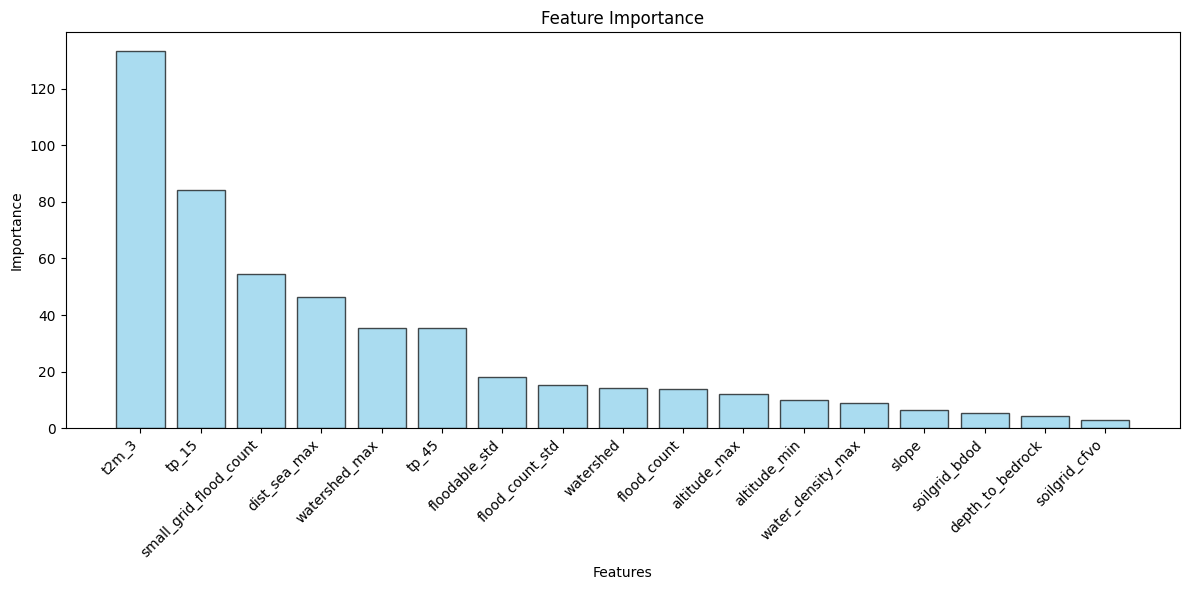

In [7]:
baseline_model_generator.print_feature_importance()

#### ROC curve

auc_graph accept a data set name (train / test / val), a metric by default it will output results for a

Train
(39006, 1)


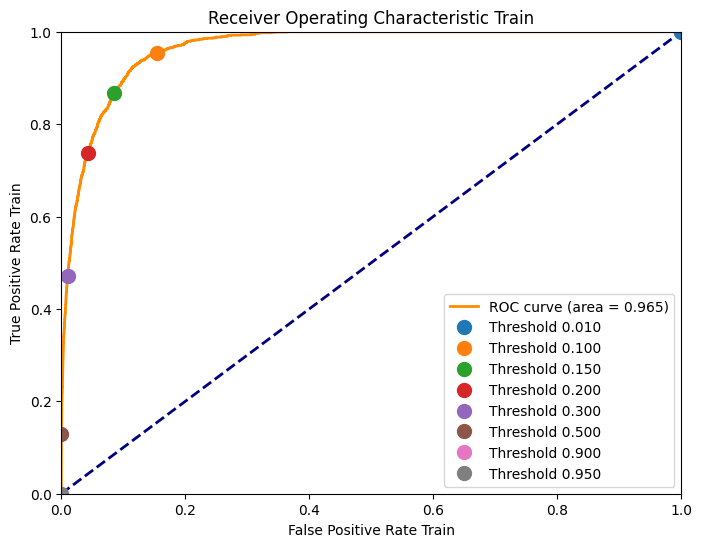

AUC: 0.9646272573788944
Test
(19503, 1)


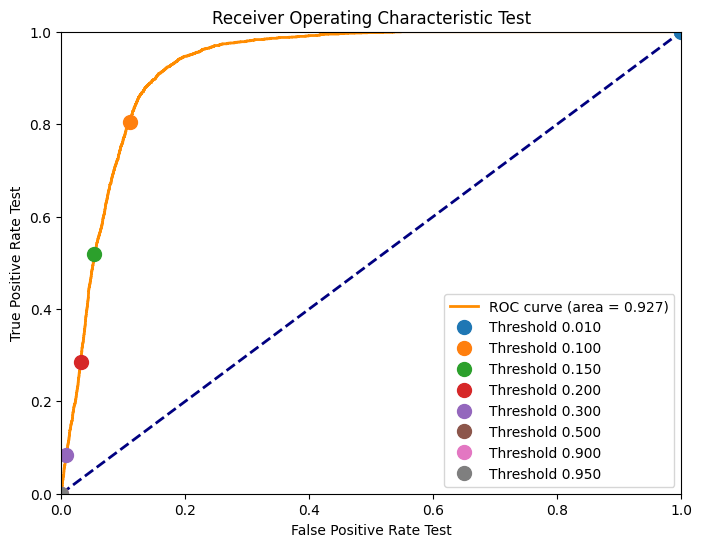

AUC: 0.9272080772691279


In [8]:
baseline_model_generator.auc_graph(dataset=["Train","Test"],metrics="", key_thresholds=[0.01,0.1,0.15, 0.2,0.3, 0.5, 0.9, 0.95])

#### Prediction map

In [9]:
baseline_model_generator.save_prediction_map(save_path = "graph/model1/predictions/")

#### Differences between labels and predictions

In [10]:
baseline_model_generator.save_prediction_map_and_labels(save_path =  "graph/model1/label_and_pred/")

#### Classification map at all threshold

In [11]:
baseline_model_generator.save_FP_FN_map(save_path = "graph/model1/FP_FN/", thresholds = [0.2, 0.3, 0.5, 0.7])

#### Error Map

In [12]:
baseline_model_generator.save_error_map(save_path="graph/model1/error_map/")

# Data computation for the second model

We choose to use the M1 model score (M1_score) as a dynamic feature for the M2 model. 
The following part create two Xarrays with M1 model score at Full Resolution and ERA5 resolution.


## Training Data
#### Creation of the M1 score Xarray at ERA5 resolution

In [13]:
baseline_model_generator.compute_full_grid()
Full_Rez = xr.open_dataset("localdata/final_label_Full_Rez.nc")

xr_array_score = xr.DataArray(baseline_model_generator.full_grid_all, 
                              dims=["time", "y", "x"],
                              coords={"time": Full_Rez.time, 
                                      "x": baseline_model_generator.labels.x, 
                                      "y": baseline_model_generator.labels.y},
                              name="M1_score")

xr_array_score = xr_array_score.astype('float32')
if os.path.exists('localdata/Model1_score_ERA5_Rez_v2.nc'):
    os.remove('localdata/Model1_score_ERA5_Rez_v2.nc')
xr_array_score.to_netcdf('localdata/Model1_score_ERA5_Rez_v2.nc', engine='h5netcdf')

In [14]:
xr_array_score = xr.open_dataset('localdata/Model1_score_ERA5_Rez_v2.nc')

#### Creation of the M1 score Xarray at Full Resolution

In [15]:
Full_Rez = xr.open_dataset("localdata/final_label_Full_Rez.nc")
small_interp = xr_array_score['M1_score'].interp(x=Full_Rez.x, y=Full_Rez.y, method='linear')
Full_Rez = Full_Rez.rename({'__xarray_dataarray_variable__': 'M1_score'})

expanded_score = Full_Rez.copy()
expanded_score['M1_score'] = small_interp

expanded_score['M1_score'] = expanded_score['M1_score'].astype('float32')

fill_value = small_interp.mean().item()
expanded_score['M1_score'] = expanded_score['M1_score'].fillna(fill_value)
if os.path.exists('localdata/Model1_Score_Full_Rez_v2.nc'):
    os.remove('localdata/Model1_Score_Full_Rez_v2.nc')
expanded_score.to_netcdf('localdata/Model1_Score_Full_Rez_v2.nc', engine='h5netcdf')

#### Sanity check
M1_score should be a float between O and 1. The presence of Nan will make the next model crash.

In [16]:
Model1_score_ERA5_Rez_v2 = xr.open_dataset('localdata/Model1_score_ERA5_Rez_v2.nc')
np.unique(Model1_score_ERA5_Rez_v2.M1_score.values)


array([0.03472859, 0.03473257, 0.03473355, ..., 0.6713946 , 0.6759996 ,
       0.6875134 ], dtype=float32)

In [17]:
Model1_Score_Full_Rez_v2 = xr.open_dataset('localdata/Model1_Score_Full_Rez_v2.nc')
np.unique(Model1_Score_Full_Rez_v2.M1_score.values)


array([0.03667939, 0.03668137, 0.03668156, ..., 0.68683094, 0.6870072 ,
       0.68718344], dtype=float32)

## Inference / Evaluation Data
#### Creation of the M1 score Xarray at ERA5 resolution

In [18]:
time_slice = baseline_model_generator.labels.sel(time=slice('2003-11-01T00:00:00.000000000','2004-01-01T00:00:00.000000000')).time.values

In [19]:
Full_Rez = xr.open_dataset("localdata/final_label_Full_Rez.nc")
xr_array_score = xr.DataArray(baseline_model_generator.full_grid_inf, 
                              dims=["time", "y", "x"],
                              coords={"time": time_slice, 
                                      "x": baseline_model_generator.labels.x, 
                                      "y": baseline_model_generator.labels.y},
                              name="M1_score")

xr_array_score = xr_array_score.astype('float32')
if os.path.exists('localdata/Model1_score_ERA5_Rez_inf.nc'):
    os.remove('localdata/Model1_score_ERA5_Rez_inf.nc')
xr_array_score.to_netcdf('localdata/Model1_score_ERA5_Rez_inf.nc', engine='h5netcdf')

In [20]:
xr_ERA5_Rez_inf = xr.open_dataset('localdata/Model1_score_ERA5_Rez_inf.nc')

#### Creation of the M1 score Xarray at Full Resolution

In [21]:
small_interp = xr_ERA5_Rez_inf['M1_score'].interp(x=Full_Rez.x, y=Full_Rez.y, method='linear')

fill_value = small_interp.mean().item()
small_interp = small_interp.fillna(fill_value)

xr_array_score = xr.DataArray(small_interp, 
                              dims=["time", "y", "x"],
                              coords={"time": time_slice, 
                                      "x": Full_Rez.x, 
                                      "y": Full_Rez.y},
                              name="M1_score")

xr_array_score = xr_array_score.astype('float32')
if os.path.exists('localdata/Model1_Score_Full_Rez_inf.nc'):
    os.remove('localdata/Model1_Score_Full_Rez_inf.nc')
xr_array_score.to_netcdf('localdata/Model1_Score_Full_Rez_inf.nc', engine='h5netcdf')

#### Sanity check

In [22]:
Model1_score_ERA5_Rez_inf = xr.open_dataset('localdata/Model1_score_ERA5_Rez_inf.nc')
np.unique(Model1_score_ERA5_Rez_inf.M1_score.values)

array([0.03479115, 0.0347991 , 0.0348    , ..., 0.61529064, 0.6233016 ,
       0.6331734 ], dtype=float32)

In [23]:
Model1_Score_Full_Rez_inf = xr.open_dataset('localdata/Model1_Score_Full_Rez_inf.nc')
np.unique(Model1_Score_Full_Rez_inf.M1_score.values)

array([0.03687995, 0.03688754, 0.03689316, ..., 0.63191944, 0.63229483,
       0.6325424 ], dtype=float32)